<div class="alert alert-block alert-info">
TODO:

* update data on Allas to newest versions and separate original data and intermediate resultsta
* fix comments, one # and talk about why only
* check spelling and grammar
* teminology check: variables/features/attributes
* make sure to make it possible to go through in 30min
</div>

## Vector data for exercises

In this course, we will use the vector dataset **Paavo**, which represents postal code area statistics collected by [Statistics Finland](https://www.stat.fi). Metadata description can be found on [Statistics Finland webpage](https://www.stat.fi/static/media/uploads/tup/paavo/paavo_kuvaus_en.pdf), see page 5 ff for field name descriptions.

The dataset includes variables about each postcode area, describing:

1. Population Structure (24 variables) HE
2. Educational Structure (7 variables) KO
3. Inhabitants' Disposable Monetary Income (7 variables) HR
4. Size and Stage in Life of Households (15 variables) TE
5. Households' Disposable Monetary Income (7 variables) TR
6. Buildings and Dwellings (8 variables) RA
7. Workplace Structure (26 variables) TP
8. Main Type of Activity (9 variables) PT

The overall goal of the exercises is to predict the median income for each zip code based on other variables/features of the dataset. 
This exercise is meant to show the different steps to prepare a vector dataset for machine learning. To make this task worth an exercise, all variables/features of type HR (that tell about the income) are removed from the dataset.

Other spatial regression problems:
* Predict age of tree based on height, circumference, location, species,...
* predict algea concentration in lakes based on season, temperature, nutrients,...
* ...

## Vector data preparations

Content of this notebook:
0. Environment preparation
1. Data retrieval
2. Data exploration
3. Feature selection
4. Feature engineering
5. Feature encoding
6. Train/Test split
7. Feature scaling
8. Store the results

In this notebook we will prepare the Paavo dataset for Machine Learning, by downloading all the necessary datasets, clean up some features, join auxiliary
data and encode text fields, split the dataset into train and test set and scale the features for machine learning purposes. We will save the result as geopackage.

The goal of this exercise is to get the dataset ready for subsequent machine learning tasks.


## 0. Environment preparation

Load all the needed Python packages. 


In [1]:

# operating system level operations
import os
# for file operations
import shutil
# filesystem exploration
import glob
# unpacking compressed files
import zipfile
# timing operations
import time
# data handling (and plotting)
import pandas as pd
# visualisation
import matplotlib.pyplot as plt
import seaborn as sns
# geospatial data handling 
import geopandas as gpd
from shapely.geometry import Point, MultiPolygon, Polygon
# Machine learning data preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder 
# download data from URL
from urllib.request import urlretrieve
# for saving the scaler, uncomment following:
# from joblib import dump

In [2]:
# for reproducible results when randomness is involved, we can set a random seed
random_seed= 42

## 1.  Data retrieval



### 1.1 Creating directories
Let's create a data directory in the base of our GeoML directory, where we store the original data.

In [3]:
username = os.environ.get('USER')
base_directory= f'/scratch/project_2002044/{username}/2022/GeoML'

def create_dir(directory_name):
    if not os.path.exists(directory_name):
        os.makedirs(directory_name)

data_directory = os.path.join(base_directory,'data')
paavo_directory=os.path.join(data_directory,'paavo')
maakunta_directory=os.path.join(data_directory,'maakunta')
preprocessed_data_directory = os.path.join(data_directory,'preprocessed_regression')

create_dir(data_directory)
create_dir(paavo_directory)
create_dir(maakunta_directory)
create_dir(preprocessed_data_directory)

### 1.2 Getting data
Let's get the original datasets that we need for this exercise from Puhtis `data` (read only) directory.
and unpack it into the just created directory. We could also remove the zip file after unpacking.

In [4]:
puhti_data_directory = '/appl/data/geo'

def copy_files(source,destination):
    for file in glob.glob(source):
        print(file)
        shutil.copy(file, destination)
               
copy_files(os.path.join(puhti_data_directory, 'tilastokeskus/paavo/2022/pno_tilasto_2022*'), paavo_directory)
copy_files(os.path.join(puhti_data_directory, 'mml/hallintorajat_10k/2021_2022/SuomenMaakuntajako_2021_10k.*'), maakunta_directory)


/appl/data/geo/tilastokeskus/paavo/2022/pno_tilasto_2022.cpg
/appl/data/geo/tilastokeskus/paavo/2022/pno_tilasto_2022.dbf
/appl/data/geo/tilastokeskus/paavo/2022/pno_tilasto_2022.prj
/appl/data/geo/tilastokeskus/paavo/2022/pno_tilasto_2022.qix
/appl/data/geo/tilastokeskus/paavo/2022/pno_tilasto_2022.shp
/appl/data/geo/tilastokeskus/paavo/2022/pno_tilasto_2022.shx
/appl/data/geo/mml/hallintorajat_10k/2021_2022/SuomenMaakuntajako_2021_10k.prj
/appl/data/geo/mml/hallintorajat_10k/2021_2022/SuomenMaakuntajako_2021_10k.dbf
/appl/data/geo/mml/hallintorajat_10k/2021_2022/SuomenMaakuntajako_2021_10k.shp
/appl/data/geo/mml/hallintorajat_10k/2021_2022/SuomenMaakuntajako_2021_10k.shx


<div class="alert alert-block alert-info">

**Reference for later: Getting data used in this notebook from Paituli**

The following commands get you the same data that we have packaged for you in Allas from CSCs [Paituli spatial data download service](https://paituli.csc.fi).

-> use wget (a command line tool, therefore we need the `!` when running it from within Jupyter, to run it in command line, remove the `!`). Note that you might have to create the `../original_data/vector/` directory first.

To get the Paavo dataset:

`!wget -r -l inf -N -np -nH -x -c --cut-dirs=4 ftp://ftp.funet.fi/index/geodata/tilastokeskus/paavo/2022/pno_tilasto_2022* -P ../original_data/vector/`

where:
-r, recursive download,
-l inf, how deep the recursive search goes, default is 5, here set to infinite,
-N, update only, do not download already existing files, this is important if download was interrupted or updating already existing data,
-np, do not download parent directories,
-nH, remove hostname,
-x, make directories similarly to Paituli,
-cuts-dirs, cut certain number of directories from the beginning to avoid too deep directory trees,
-c, continue broken download.

Ftp stands for file transfer protocol and should be preferred when downloading files from the internet (if available)

To get administrative borders:

`!wget -r -l inf -N -np -nH -x -c --cut-dirs=4 ftp://ftp.funet.fi/index/geodata/mml/hallintorajat_10k/2020_2022/SuomenMaakuntajako_2021_10k* -P ../original_data/vector/`

</div>


### 1.3 Storing file locations

In order to use the data later, we store their path and filename in variables.

In [24]:
#inputfiles
paavo_shapefile = os.path.join(paavo_directory,'pno_tilasto_2022.shp')
finnish_regions_shapefile = os.path.join(maakunta_directory, 'SuomenMaakuntajako_2021_10k.shp')

#outputfiles
scaled_train_dataset_name = os.path.join(preprocessed_data_directory,'scaled_train_zip_code_data.csv')
scaled_test_dataset_name = os.path.join(preprocessed_data_directory,'scaled_test_zip_code_data.csv')
scaled_val_dataset_name = os.path.join(preprocessed_data_directory,'scaled_val_zip_code_data.csv')
train_label_name = os.path.join(preprocessed_data_directory,'train_income_labels.pkl')
test_label_name = os.path.join(preprocessed_data_directory,'test_income_labels.pkl')
val_label_name = os.path.join(preprocessed_data_directory,'val_income_labels.pkl')
train_dataset_name = os.path.join(preprocessed_data_directory,'train_zip_code_data.csv')
test_dataset_name = os.path.join(preprocessed_data_directory,'test_zip_code_data.csv')
val_dataset_name = os.path.join(preprocessed_data_directory,'val_zip_code_data.csv')

# optional to store the scaler
#scaler_path = '../original_data/paavo/zip_code_scaler.bin'

## 2. Data exploration

Always get to know your data before even thinking about Machine Learning. This section shows a few ways that we can get to know Paavo dataset a bit better. Possibilities are endless. For some models, you should also check that assumptions the model makes about data distribution are true.

### 2.1 Read the data into dataframe

Read the zip code dataset into a geopandas dataframe `original_gdf`:

In [6]:
# defining the encoding makes sure that characters are represented as intended, important especially with languages that have "special characters" 
original_gdf = gpd.read_file(paavo_shapefile, encoding='utf-8')
original_gdf


,postinumer,nimi,namn,euref_x,euref_y,pinta_ala,kunta,he_vakiy,he_naiset,he_miehet,...,tp_u_kans,tp_x_tunt,pt_vakiy,pt_tyoll,pt_tyott,pt_0_14,pt_opisk,pt_elakel,pt_muut,geometry
0,00100,Helsinki keskusta - Etu-Töölö,Helsingfors centrum - Främre Tölö,384979,6672361,2.353278e+06,091,18373,9689,8684,...,45,0,18334,10412,578,1850,1336,3375,783,"POLYGON ((385653.893 6671591.048, 385573.619 6..."
1,00120,Punavuori - Bulevardi,Rödbergen - Bulevarden,385531,6671434,4.140100e+05,091,7216,3792,3424,...,17,2,7140,3990,236,831,468,1240,375,"POLYGON ((385316.092 6671076.984, 385279.611 6..."
2,00130,Kaartinkaupunki,Gardesstaden,386244,6671474,4.289600e+05,091,1721,889,832,...,73,0,1582,887,30,175,121,268,101,"POLYGON ((386212.111 6671061.262, 386176.826 6..."
3,00140,Kaivopuisto - Ullanlinna,Brunnsparken - Ulrikasborg,386394,6670766,9.318410e+05,091,7995,4339,3656,...,86,0,7958,4246,250,990,522,1528,422,"MULTIPOLYGON (((386577.050 6670280.544, 386552..."
4,00150,Punavuori - Eira - Hernesaari,Rödbergen - Eira - Ärtholmen,385320,6670373,1.367328e+06,091,9440,5088,4352,...,3,0,9420,5460,356,981,586,1544,493,"MULTIPOLYGON (((384846.102 6669565.816, 384823..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3022,99930,Sevettijärvi-Näätämö,Sevettijärvi-Näätämö,544895,7710278,2.660557e+09,148,216,86,130,...,-1,-1,218,99,16,16,7,73,7,"POLYGON ((574352.412 7709596.307, 573122.354 7..."
3023,99940,Näätämö,Näätämö,581949,7714377,3.470458e+08,148,27,-1,-1,...,0,0,27,-1,-1,-1,-1,-1,-1,"POLYGON ((573536.965 7681842.036, 572505.216 7..."
3024,99950,Karigasniemi,Karigasniemi,471619,7700224,1.800547e+09,890,286,122,164,...,0,0,289,130,8,51,10,76,14,"POLYGON ((450197.347 7670193.165, 450054.015 7..."
3025,99980,Utsjoki Keskus,Utsjoki centrum,497850,7729733,2.858975e+09,890,685,328,357,...,0,0,675,264,19,84,29,263,16,"POLYGON ((519583.786 7768425.325, 519615.030 7..."


### 2.2 Exploring the dataframe


In [7]:
# dataframe columns and rows
print(f"Original dataframe size: {len(original_gdf.index)} rows (= zip codes) with {len(original_gdf.columns)} columns (=variables/features)")
# column names
print(list(original_gdf.columns))

Original dataframe size: 3027 rows (= zip codes) with 112 columns (=variables/features)
['postinumer', 'nimi', 'namn', 'euref_x', 'euref_y', 'pinta_ala', 'kunta', 'he_vakiy', 'he_naiset', 'he_miehet', 'he_kika', 'he_0_2', 'he_3_6', 'he_7_12', 'he_13_15', 'he_16_17', 'he_18_19', 'he_20_24', 'he_25_29', 'he_30_34', 'he_35_39', 'he_40_44', 'he_45_49', 'he_50_54', 'he_55_59', 'he_60_64', 'he_65_69', 'he_70_74', 'he_75_79', 'he_80_84', 'he_85_', 'ko_ika18y', 'ko_perus', 'ko_koul', 'ko_yliop', 'ko_ammat', 'ko_al_kork', 'ko_yl_kork', 'hr_tuy', 'hr_ktu', 'hr_mtu', 'hr_pi_tul', 'hr_ke_tul', 'hr_hy_tul', 'hr_ovy', 'te_taly', 'te_takk', 'te_as_valj', 'te_yks', 'te_nuor', 'te_eil_np', 'te_laps', 'te_plap', 'te_aklap', 'te_klap', 'te_teini', 'te_yhlap', 'te_aik', 'te_elak', 'te_omis_as', 'te_vuok_as', 'te_muu_as', 'tr_kuty', 'tr_ktu', 'tr_mtu', 'tr_pi_tul', 'tr_ke_tul', 'tr_hy_tul', 'tr_ovy', 'ra_ke', 'ra_raky', 'ra_muut', 'ra_asrak', 'ra_asunn', 'ra_as_kpa', 'ra_pt_as', 'ra_kt_as', 'ra_muu_as', 't

In [8]:
# column data types
print(list(pd.unique(original_gdf.dtypes)))

[dtype('O'), dtype('int64'), dtype('float64'), <geopandas.array.GeometryDtype object at 0x7f7c8b2016a0>]


In [9]:
# check for nodata isna/null gives True/False , summing gives +1 for each True for each column, summing again gives total amount of True for the whole dataframe
print(original_gdf.isna().sum().sum())
print(original_gdf.isnull().sum().sum())

0
0


In [10]:
# check for unsensible cells 
# e.g. income equal to or below 0
print(len(original_gdf[original_gdf["hr_mtu"]==0]))
print(len(original_gdf[original_gdf["hr_mtu"]<0]))

19
71


In [11]:
# get value range of each column
for x in original_gdf.columns:
    if original_gdf[x].dtype in ['int64','float64']:
        min = original_gdf[x].min()
        max = original_gdf[x].max()
        print(f'Value range of {x} : {str(min)} to {str(max)}')

Value range of euref_x : 90361 to 720123
Value range of euref_y : 6639963 to 7750572
Value range of pinta_ala : 81759.0 to 7052404652.0
Value range of he_vakiy : 0 to 28449
Value range of he_naiset : -1 to 15430
Value range of he_miehet : -1 to 13615
Value range of he_kika : -1 to 80
Value range of he_0_2 : -1 to 797
Value range of he_3_6 : -1 to 1144
Value range of he_7_12 : -1 to 1664
Value range of he_13_15 : -1 to 871
Value range of he_16_17 : -1 to 582
Value range of he_18_19 : -1 to 643
Value range of he_20_24 : -1 to 4517
Value range of he_25_29 : -1 to 3832
Value range of he_30_34 : -1 to 2667
Value range of he_35_39 : -1 to 1897
Value range of he_40_44 : -1 to 1613
Value range of he_45_49 : -1 to 1534
Value range of he_50_54 : -1 to 1778
Value range of he_55_59 : -1 to 1823
Value range of he_60_64 : -1 to 1520
Value range of he_65_69 : -1 to 1494
Value range of he_70_74 : -1 to 1594
Value range of he_75_79 : -1 to 1213
Value range of he_80_84 : -1 to 876
Value range of he_85_ 

It seems like `-1` is used as no data value. We can keep and remember this as is, or replace all `-1` with `np.nan` which can for example later be interpolated or removed.

### 2.3 Visualization

Another way of data exploration is visualizing different features of your dataset in different ways to reveal phenonemons that might not be visible when looking at numbers only.

#### 2.3.1 Distribution plot

In this exercise, we are interested in the income per capita. So let's check out the distribution of that target feature by plotting a distribution plot with seaborn `distplot` functionality.


In [12]:
# reminder on how to get help within notebook
help(sns.histplot)

Help on function displot in module seaborn.distributions:

displot(data=None, *, x=None, y=None, hue=None, row=None, col=None, weights=None, kind='hist', rug=False, rug_kws=None, log_scale=None, legend=True, palette=None, hue_order=None, hue_norm=None, color=None, col_wrap=None, row_order=None, col_order=None, height=5, aspect=1, facet_kws=None, **kwargs)
    Figure-level interface for drawing distribution plots onto a FacetGrid.
    
    This function provides access to several approaches for visualizing the
    univariate or bivariate distribution of data, including subsets of data
    defined by semantic mapping and faceting across multiple subplots. The
    ``kind`` parameter selects the approach to use:
    
    - :func:`histplot` (with ``kind="hist"``; the default)
    - :func:`kdeplot` (with ``kind="kde"``)
    - :func:`ecdfplot` (with ``kind="ecdf"``; univariate-only)
    
    Additionally, a :func:`rugplot` can be added to any kind of plot to show
    individual observations.


<AxesSubplot: xlabel='hr_mtu', ylabel='Count'>

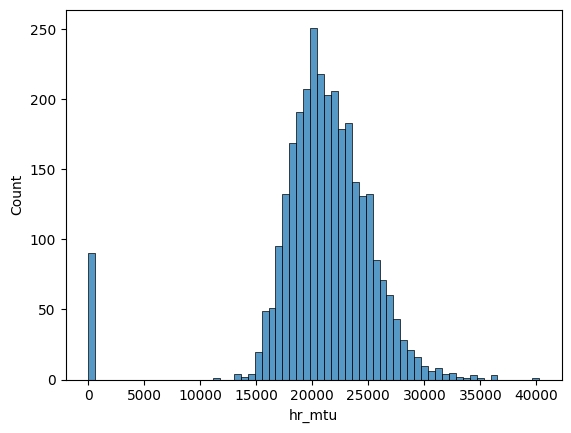

In [13]:
# using seaborn histogram plot
sns.histplot(original_gdf['hr_mtu'])
# other option:
#original_gdf['hr_mtu'].hist()
# another option to identify outliers would be to use boxplot 
#sns.boxplot(original_gdf['hr_mtu'])

We can see that some zip codes have an income of 0, which in this case probably means "no data available".

#### 2.3.2 Map
As we are working with spatial data, we can also plot a map of the target feature to explore its spatial distribution.

If plotting maps with matplotlib is not familiar. Here are some things you can play with
* **figsize** - different height, width
* **column** - try other features
* **cmap** - this is the color map, here are the possibile options https://matplotlib.org/3.3.1/tutorials/colors/colormaps.html

The following plots are only for quick visualization, to include these plots in publications, more features would need to be taken care of ( such as axes and their labels, north arrow, colorblind and print friendly color palette,...)

epsg:3067


Text(1665.152777777778, 0.5, 'Income in €')

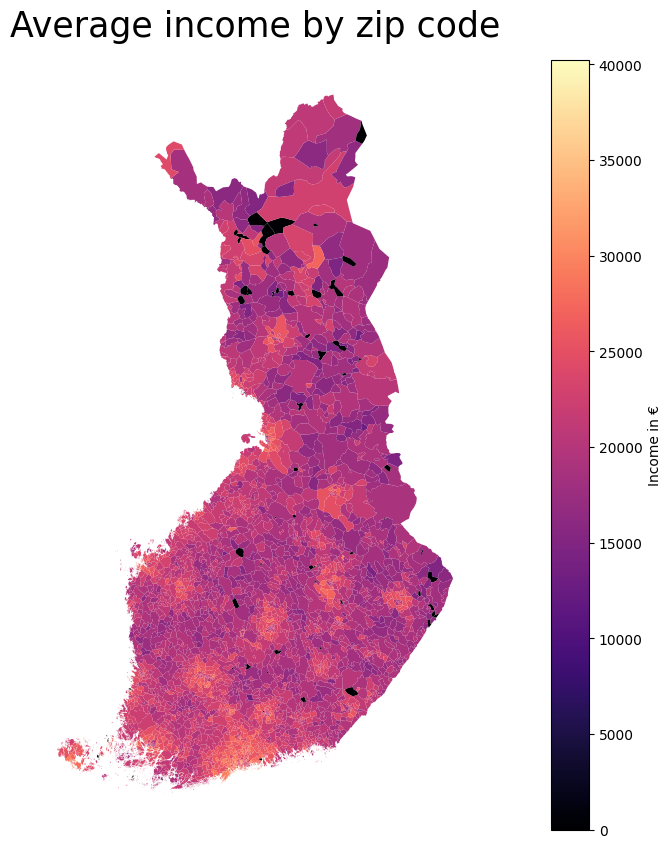

In [14]:
# check coordinate reference frame
print(original_gdf.crs)

fig, ax = plt.subplots(figsize=(20, 10))
# set title for the full plot
ax.set_title("Average income by zip code", fontsize=25)
# turn off all axes
ax.set_axis_off()
# plot the average income
plot = original_gdf.plot(column='hr_mtu', ax=ax, legend=True, cmap="magma")
# set colorbar label
cax = fig.get_axes()[1]
cax.set_ylabel('Income in €');

#### 2.3.3 Regression plots

We can also explore, how the different features are related to another by plotting them "against each other" by plotting some regression plots, i.e. scatter plots with a "best fitting" regression line. 

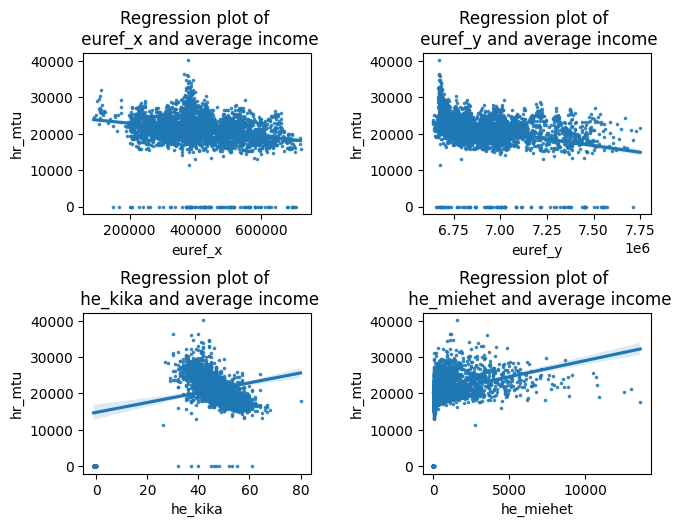

In [15]:
# choose some variables
variables = ['euref_x', 'euref_y', 'he_kika','he_miehet']
fig,ax = plt.subplots(2,2)
# to fit all titles and axes labels
fig.tight_layout(h_pad=5,w_pad=5)

# ravel axes to loop through and fill subplots one by one
for var,axes in zip(variables, ax.ravel()):
    # Regression Plot also by default includes best-fitting regression line which can be turned off via `fit_reg=False`
    sns.regplot(x=var, y='hr_mtu', data=original_gdf,  marker='.', scatter_kws = {'s': 10},ax = axes).set(title=f'Regression plot of \n {var} and average income');

## 3. Feature selection

We have a lot of features available. 
It usually make sens to check for empty rows and columns as well as empty single cells and either remove them from the dataset or, if domain knowledge allows, fill them with sensible values. Note that this might have significant impact on the results. So fill with care, and if unsure, rather remove.


In [16]:
# Drop all rows that have missing values or where average income is -1 (=not known) or 0
selected_gdf = original_gdf.dropna()
selected_gdf = selected_gdf[selected_gdf["hr_mtu"]>0].reset_index(drop=True)

print(f"Dataframe size after dropping no data (for income) rows: {len(selected_gdf.index)} zip codes with {len(selected_gdf.columns)} columns")

# Remove some columns that are strings (namn, kunta = name of the municipality in Finnish and Swedish.)
# or which might make the modeling too easy as directly realted to inhabitants income ('hr_mtu','hr_tuy','hr_pi_tul','hr_ke_tul','hr_hy_tul','hr_ovy') or household income ('tr_ktu', 'tr_mtu')
columns_to_be_removed_completely = ['namn','kunta','hr_ktu','hr_tuy','hr_pi_tul','hr_ke_tul','hr_hy_tul','hr_ovy', 'tr_ktu', 'tr_mtu']
selected_gdf = selected_gdf.drop(columns_to_be_removed_completely,axis=1)

print(f"Dataframe size after dropping columns with string values and columns that make modeling too easy : {len(selected_gdf.index)} zip codes with {len(selected_gdf.columns)} columns")

Dataframe size after dropping no data (for income) rows: 2937 zip codes with 112 columns
Dataframe size after dropping columns with string values and columns that make modeling too easy : 2937 zip codes with 102 columns


## 4. Feature engineering

This section does not include any computations, as this goes out of scope of the course and is mainly geospatial processing that is not specific to machine learning.

Sometimes, the features as they come from the dataset can be further refined to represent the data in a way that is easier to use for modelling. One example would be to calculate the ratio or some other statistical measure of two or multiple features. This step requires domain knowledge to find sensible features. In this step you can also again think about, what additional datasets could be used to add information for the task.

In the spatial domain, incorporating the neighborhood of each zip-code into features could be one way of feature engineering.

For example, we expect (=domain knowledge) that people with higher income can afford to live in cities and near lakes or some national park. So we could also engineer some features that represent these factors with additional datasets:

* distance to closest city center, which can be gotten from naturalearth populated places dataset (link xxx)
* number of lakes in the area (e.g. 5km radius), SYKE water areas (link xxx)
* distance to closest national park, SYKE state areas of natural protection (link xxx)

In the temporal domain, if we are working with timeseries, but not with specific time series models, we could create features representing the temporal domain, such as the ratio of a two timepoints of the same variable.

Be creative! 

> Note: Make sure that you can create the same features also for future datasets that you might want to apply your model to.


## 5. Feature encoding

* Most Machine Learning algorithms cannot handle categorical features per se, they have to be converted to numerical values
* Categorical features can be binary (True/False, 1/0), ordinal (low,medium,high) or nominal (monkey, donkey, tiger, penguin)

To practice, we can add region names to the post codes. One of the most-used encoding techniques is **one-hot encoding**. This means that instead of one column with different names, we create <number of unique values in column> new columns and fill then with 1/0. 
-> Same information content but numerical cells and no hierarchy (as we would get when simply assigning a numerical value to each string) 
-> also called "dummy variables"

We use the pandas **get_dummies()** function for one-hot encoding. Scikit would also have a **OneHotEncoder()** transformer for this

* More information on one-hot encoding https://www.kaggle.com/dansbecker/using-categorical-data-with-one-hot-encoding
* It might not always be the best option. See other options https://towardsdatascience.com/stop-one-hot-encoding-your-categorical-variables-bbb0fba89809

### 5.1 Spatially join the region information to the dataset 

First we need to bring the two dataframes together. We want to know which region each zip code are is in, so we want to "spatially join" the two dataframes. As the zip code areas might overlap several regions, let's choose that region for each zip code, where the mid point of each zip code polygon falls in.

In [17]:
# Read the regions shapefile and select only the name of the region and its geometry
finnish_regions_gdf = gpd.read_file(finnish_regions_shapefile)
finnish_regions_gdf = finnish_regions_gdf[['NAMEFIN','geometry']]

# A function we use to return centroid point geometry from a zip code polygon
def returnPointGeometryFromXY(polygon_geometry):
    ## Calculate x and y of the centroid
    centroid_x,centroid_y = polygon_geometry.centroid.x,polygon_geometry.centroid.y
    ## Create a shapely Point geometry of the x and y coords
    point_geometry = Point(centroid_x,centroid_y)
    return point_geometry

# Stash the polygon geometry to another column as we are going to overwrite the 'geometry' with centroid geometry
selected_gdf['polygon_geometry'] = selected_gdf['geometry']

# We will be joining the region name to zip codes according to the zip code centroid. 
# This calls the function above and returns centroid to every row
selected_gdf["geometry"] = selected_gdf['geometry'].apply(returnPointGeometryFromXY)

# Spatially join the region name to the zip codes using the centroid of zip codes and region polygons
selected_and_joined_gdf = gpd.sjoin(selected_gdf,finnish_regions_gdf,how='inner',op='intersects')
# look at the end of the dataframe to see if it worked (the beginning of the dataframe has too many zip codes in same area)
selected_and_joined_gdf.tail()


/usr/local/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3473: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


,postinumer,nimi,euref_x,euref_y,pinta_ala,he_vakiy,he_naiset,he_miehet,he_kika,he_0_2,...,pt_tyoll,pt_tyott,pt_0_14,pt_opisk,pt_elakel,pt_muut,geometry,polygon_geometry,index_right,NAMEFIN
2932,99910,Kaamanen-Partakko,501485,7678364,1.786437e+09,162,71,91,54,4,...,43,9,14,17,78,6,POINT (503360.688 7678510.874),"POLYGON ((525777.302 7700650.894, 525850.693 7...",7,Lappi
2933,99930,Sevettijärvi-Näätämö,544895,7710278,2.660557e+09,216,86,130,52,1,...,99,16,16,7,73,7,POINT (548890.499 7711837.059),"POLYGON ((574352.412 7709596.307, 573122.354 7...",7,Lappi
2934,99950,Karigasniemi,471619,7700224,1.800547e+09,286,122,164,46,3,...,130,8,51,10,76,14,POINT (471402.146 7701544.993),"POLYGON ((450197.347 7670193.165, 450054.015 7...",7,Lappi
2935,99980,Utsjoki Keskus,497850,7729733,2.858975e+09,685,328,357,50,14,...,264,19,84,29,263,16,POINT (502680.384 7734902.492),"POLYGON ((519583.786 7768425.325, 519615.030 7...",7,Lappi
2936,99990,Nuorgam,539074,7750572,7.743531e+08,201,92,109,46,5,...,92,9,32,15,53,9,POINT (536019.915 7755327.036),"POLYGON ((538700.093 7735625.716, 531298.591 7...",7,Lappi


### 5.2 One-hot encode the region name

Let's practice now the one-hot encoding on the spatially joined dataframe.

In [18]:
# Switch the polygon geometry back to the 'geometry' field and drop not needed columns
selected_and_joined_gdf['geometry'] = selected_and_joined_gdf['polygon_geometry']
selected_and_joined_gdf.drop(['index_right','polygon_geometry'],axis=1, inplace=True)

# Encode the region name with One-hot encoder (= in pandas, dummy encoding)
ohencoder = OneHotEncoder()
encoded_gdf = pd.get_dummies(selected_and_joined_gdf['NAMEFIN'])

col_names_no_scaling = list(encoded_gdf.columns)

# Join original gdf and encoded gdf together
new_encoded_gdf = selected_and_joined_gdf.join(encoded_gdf).drop('NAMEFIN',axis=1)

# The resulting dataframe has Polygon and Multipolygon geometries. 
# This upcasts the polygons to multipolygon format so all of them have the same format
new_encoded_gdf["geometry"] = [MultiPolygon([feature]) if type(feature) == Polygon else feature for feature in new_encoded_gdf["geometry"]]
print("Dataframe size after adding region name: " + str(len(new_encoded_gdf.index))+ " zip codes with " + str(len(new_encoded_gdf.columns)) + " columns")

# Print the tail of the dataframe
new_encoded_gdf.tail()

Dataframe size after adding region name: 2937 zip codes with 121 columns


,postinumer,nimi,euref_x,euref_y,pinta_ala,he_vakiy,he_naiset,he_miehet,he_kika,he_0_2,...,Lappi,Pirkanmaa,Pohjanmaa,Pohjois-Karjala,Pohjois-Pohjanmaa,Pohjois-Savo,Päijät-Häme,Satakunta,Uusimaa,Varsinais-Suomi
2932,99910,Kaamanen-Partakko,501485,7678364,1.786437e+09,162,71,91,54,4,...,1,0,0,0,0,0,0,0,0,0
2933,99930,Sevettijärvi-Näätämö,544895,7710278,2.660557e+09,216,86,130,52,1,...,1,0,0,0,0,0,0,0,0,0
2934,99950,Karigasniemi,471619,7700224,1.800547e+09,286,122,164,46,3,...,1,0,0,0,0,0,0,0,0,0
2935,99980,Utsjoki Keskus,497850,7729733,2.858975e+09,685,328,357,50,14,...,1,0,0,0,0,0,0,0,0,0
2936,99990,Nuorgam,539074,7750572,7.743531e+08,201,92,109,46,5,...,1,0,0,0,0,0,0,0,0,0


## 6. Train- Test split

In order to determine later, how well our models perform on previously unseen data we need to split the dataset into so-called `train`, `test` and `validation` dataset. We use the `train` dataset during model training, so our regressor gets to know that dataset really well. Then we will use our `validation` dataset to finetune the parameters of our models, i.e. we use knowledge gained from applying the trained model on unseen data to adapt the parameters. That means that this dataset is no longer unknown to the model. So we need a third new dataset (`test`) to finally test how well the model performs on previously unseen data.

![](../images/supervised_workflow.png)



In [20]:
# Split the gdf to x (the predictor attributes) and y (the attribute to be predicted)
y = new_encoded_gdf['hr_mtu'] # Average income

# Remove geometry and textual fields
x = new_encoded_gdf.drop(['geometry','postinumer','nimi','hr_mtu'],axis=1)

# Split both datasets to train (60%) and test (40%) datasets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.4, random_state=random_seed)

# Split the test dataset in half, to get 20% validation and 20% test dataset
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=.5, random_state=random_seed)

# \n tells the print command to start a new line
print(f'Shape of train dataset: {x_train.shape} \n Shape of test dataset: {x_test.shape} \n Shape of validation dataset: {x_val.shape}')
        
x_train = x_train.reset_index(drop=True)
x_test = x_test.reset_index(drop=True)
x_val = x_val.reset_index(drop=True)

['euref_x', 'euref_y', 'pinta_ala', 'he_vakiy', 'he_naiset', 'he_miehet', 'he_kika', 'he_0_2', 'he_3_6', 'he_7_12', 'he_13_15', 'he_16_17', 'he_18_19', 'he_20_24', 'he_25_29', 'he_30_34', 'he_35_39', 'he_40_44', 'he_45_49', 'he_50_54', 'he_55_59', 'he_60_64', 'he_65_69', 'he_70_74', 'he_75_79', 'he_80_84', 'he_85_', 'ko_ika18y', 'ko_perus', 'ko_koul', 'ko_yliop', 'ko_ammat', 'ko_al_kork', 'ko_yl_kork', 'te_taly', 'te_takk', 'te_as_valj', 'te_yks', 'te_nuor', 'te_eil_np', 'te_laps', 'te_plap', 'te_aklap', 'te_klap', 'te_teini', 'te_yhlap', 'te_aik', 'te_elak', 'te_omis_as', 'te_vuok_as', 'te_muu_as', 'tr_kuty', 'tr_pi_tul', 'tr_ke_tul', 'tr_hy_tul', 'tr_ovy', 'ra_ke', 'ra_raky', 'ra_muut', 'ra_asrak', 'ra_asunn', 'ra_as_kpa', 'ra_pt_as', 'ra_kt_as', 'ra_muu_as', 'tp_tyopy', 'tp_alku_a', 'tp_jalo_bf', 'tp_palv_gu', 'tp_a_maat', 'tp_b_kaiv', 'tp_c_teol', 'tp_d_ener', 'tp_e_vesi', 'tp_f_rake', 'tp_g_kaup', 'tp_h_kulj', 'tp_i_majo', 'tp_j_info', 'tp_k_raho', 'tp_l_kiin', 'tp_m_erik', 'tp_n_

## 7. Feature Scaling

Feature Scaling is one of the most important data preparation steps. This is to avoid biasing algorithms that compute distances between features (e.g. like KNN, SVM and other non-treebased) towards numerically larger values. Feature scaling also helps the algorithm to train and converge faster.
The most popoular scaling techniques are normalization and standardization. Both scale the values of the current cell based on all given other cells, this means that scaling has to be done before train/test split to avoid bias towards unseen data. Apply to test set afterwards.

## 7.1 Normalization or min-max scaling 

* X_new = (X - X_min)/(X_max - X_min)
* Used when features are of different scales, eg average size of household (te_takk) and number of inhabitants of a certain age class (he_x_y) 
* Scales the values into range [0,1] or [-1,1]
* Data should not have any large outliers (data exploration!), as the rest of the data will be squashed into narrow range. -> Standardization is better option
* Scikit-learn: [MinMaxScaler()](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)

## 7.2 Standardization or Z-score normalization

* X_new = (X - mean)/std
* Used when "zero mean and unit standard deviation" needs to be ensured, we are standardizing to achieve equal variance of features
* Not bound to specific range
* less affected by outliers, as range is not set outliers will not have influence on the range of other values
* "1 implies that the value for that case is one standard deviation above the mean"
* Scikit-learn: [StandardScaler()](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler)


In [21]:
# Get list of all column headings
all_columns = list(x_train.columns)

print(all_columns)
print(col_names_no_scaling)
#col_names_no_scaling.extend(['geometry','postinumer','nimi','hr_mtu'])
print(col_names_no_scaling)

# List of column names we want to scale. (all columns minus those we don't want)
col_names_to_scale = [column for column in all_columns if column not in col_names_no_scaling]

# Subset the data for only those to-be scaled
x_train_to_scale = x_train[col_names_to_scale]
# we do not need to scale the label, but we also need to scale the test and validation data
x_test_to_scale = x_test[col_names_to_scale]
x_val_to_scale = x_val[col_names_to_scale]


# Apply a Scikit StandardScaler() or MinMaxScaler() for all the columns left in dataframe
# You can also test both, rename variable `train/test/val_dataset_name` after running the remaining cells with one scaler, to not overwrite results
scaler = StandardScaler()
#scaler = MinMaxScaler()

# You can save the scaler for later use. If there suddenly would be more zip codes in Finland, we should use the same scaler.
# dump(scaler, scaler_path, compress=True)

# We fit the scaler to the training dataset and transform the trainin dataset
scaled_x_train_array = scaler.fit_transform(x_train_to_scale)

# we also need to scale x_test and x_val with the same scaler, note that we only transform , not fit the test data
scaled_x_test_array = scaler.transform(x_test_to_scale)
scaled_x_val_array = scaler.transform(x_val_to_scale)

# Result is a numpy ndarray, which we pack back into geopandas dataframe
# Join the non-scaled columns back with the the scaled columns by index and drop all rows that have nodata values after scaling
def to_pandas_and_rejoin(scaled_array, col_names_to_scale, unscaled_data):
    scaled_x = pd.DataFrame(scaled_array)
    scaled_x.columns = col_names_to_scale
    full_scaled_x = scaled_x.join(unscaled_data).dropna()
    return full_scaled_x
    

full_scaled_x_train = to_pandas_and_rejoin(scaled_x_train_array, col_names_to_scale, x_train[col_names_no_scaling])
full_scaled_x_test = to_pandas_and_rejoin(scaled_x_test_array, col_names_to_scale, x_test[col_names_no_scaling])
full_scaled_x_val = to_pandas_and_rejoin(scaled_x_val_array, col_names_to_scale, x_val[col_names_no_scaling])


['euref_x', 'euref_y', 'pinta_ala', 'he_vakiy', 'he_naiset', 'he_miehet', 'he_kika', 'he_0_2', 'he_3_6', 'he_7_12', 'he_13_15', 'he_16_17', 'he_18_19', 'he_20_24', 'he_25_29', 'he_30_34', 'he_35_39', 'he_40_44', 'he_45_49', 'he_50_54', 'he_55_59', 'he_60_64', 'he_65_69', 'he_70_74', 'he_75_79', 'he_80_84', 'he_85_', 'ko_ika18y', 'ko_perus', 'ko_koul', 'ko_yliop', 'ko_ammat', 'ko_al_kork', 'ko_yl_kork', 'te_taly', 'te_takk', 'te_as_valj', 'te_yks', 'te_nuor', 'te_eil_np', 'te_laps', 'te_plap', 'te_aklap', 'te_klap', 'te_teini', 'te_yhlap', 'te_aik', 'te_elak', 'te_omis_as', 'te_vuok_as', 'te_muu_as', 'tr_kuty', 'tr_pi_tul', 'tr_ke_tul', 'tr_hy_tul', 'tr_ovy', 'ra_ke', 'ra_raky', 'ra_muut', 'ra_asrak', 'ra_asunn', 'ra_as_kpa', 'ra_pt_as', 'ra_kt_as', 'ra_muu_as', 'tp_tyopy', 'tp_alku_a', 'tp_jalo_bf', 'tp_palv_gu', 'tp_a_maat', 'tp_b_kaiv', 'tp_c_teol', 'tp_d_ener', 'tp_e_vesi', 'tp_f_rake', 'tp_g_kaup', 'tp_h_kulj', 'tp_i_majo', 'tp_j_info', 'tp_k_raho', 'tp_l_kiin', 'tp_m_erik', 'tp_n_

# 8. Store the results

We will need the results of this notebook in two further notebooks, so we will store the prepared train and test datasets into gpkg. 
We also store the labels for train and test datasets.

In [25]:
# Write the prepared train and test zipcode datasets to csv
full_scaled_x_train.to_csv(scaled_train_dataset_name, index=False)
full_scaled_x_test.to_csv(scaled_test_dataset_name, index=False)
full_scaled_x_val.to_csv(scaled_val_dataset_name, index=False)

# You can also store the unscaled train, test and validation datasets, which can be used with tree-based models
x_train.to_csv(train_dataset_name, index=False)
x_test.to_csv(test_dataset_name, index=False)
x_val.to_csv(val_dataset_name, index=False)

# Write the labels to pickle, as we do not need to read it outside of these notebooks, otherwise json or csv would be more compatible options
y_train.to_pickle(train_label_name)
y_test.to_pickle(test_label_name)
y_val.to_pickle(val_label_name)